## Adversarial Debiasing for Images

### Table of contents :
1. [Introduction](#1.-Introduction)
2. [Data preparation](#2.-Data-prpeparation)
3. [Classifier network](#3.-Classifier-network)
	*  [Model Fairness for Classifier Network](#Model-Fairness-for-Classifier-Network)
4. [Mitigate the model bias with Adversarial networks](#4.-Mitigate-the-model-bias-with-Adversarial-networks)
	* [Model Fairness for Adversarial networks](#Model-Fairness-for-Adversarial-networks)
5. [Summary](#5.-Summary)
6. [References](#6.-References)

### 1. Introduction

Welcome !

We hope you have had a chance to go through previous tutorials on fairness in AI by Sony. In one of the tutorials, we had touched upon an in-processing technique(adversarial debiasing) for bias mitigation. There, we applied adversarial training to a classification task on UCI Adult (Census) Dataset. As a result, predictive model model fairness improved without causing much drop in accuracy.

In this tutorial, we will focus on exploring adversarial debiasing for visual recognition task on real-world CelebA dataset. As discussed in the previous tutorial, adversarial debiasing procedure takes inspiration from GANs (Goodfellow et al. 2014), to train a fair classifier. Here, we build two models
1. Classfier model 
2. Adversary model 

Before we go into a detailed explanation of the adversary training procedure, here is a sneak peek into the steps involved in the process

### Preparation
Let's start by installing nnabla and accessing [nnabla-examples repository](https://github.com/sony/nnabla-examples). If you're running on Colab, make sure that your Runtime setting is set as GPU, which can be set up from the top menu (Runtime → change runtime type), and make sure to click **Connect** on the top right-hand side of the screen before you start.

In [ ]:
# Preparation
# May show warnings for newly imported packages if run in Colab default python environment.
# Please click the `RESTART RUNTIME` to run the following script correctly.
# The error message of conflicts is acceptable.
!git clone https://github.com/sony/nnabla-examples.git
!pip install albumentations
!pip install nnabla-ext-cuda116

In [ ]:
%cd nnabla-examples/responsible_ai/adversarial_debiasing_images

In [1]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('images/adversarial_debiasing_workflow_diagram.png')
cv2_imshow(img)

As illustrated in the picture, in the first step we will train a classifier model to make predictions, analyze model fairness, and then the second step shows how adversarial training can be employed to make the model fair if the fairness metric is not up to the mark.

At first, all we need is to import all the necessary python libraries which are being used in all the steps

In [1]:
import os
import glob
import pickle
import shutil
import numpy as np
from PIL import Image
import albumentations as A
import nnabla as nn
from nnabla.utils.data_iterator import data_iterator_simple
import adversarial as adv
import basemodel as clf
from utils import utils

2022-04-20 11:26:17,247 [nnabla][INFO]: Initializing CPU extension...


Let us train an `Attractive` classifier that is not dependent on gender expression. For this, we require a dataset that has target labels (`Attractive`) as well as gender expression labels. 


NNabla provides various utilities for using data for training/validation. Here, we will use NNabla data_iterator_simple.

### 2. Data prpeparation

Before training a classifier model, let's download and split CelebA dataset into three categories: one for training and remaining two sets for validating and testing the classifier model respectively.

In [ ]:
# download the celeba dataset and unzip
URL = "https://www.dropbox.com/s/d1kjpkqklf0uw77/celeba.zip?dl=0"
ZIP_FILE= "./data/celeba.zip"
!mkdir -p ./data/
!wget -N $URL -O $ZIP_FILE
!unzip $ZIP_FILE -d ./data/
!rm $ZIP_FILE

In [3]:
def split_celeba_dataset(img_path, attr_path, out_dir, split="test"):
    
    """
    split the celebA dataset
    Args:
        img_path (str) : image path directory 
        attr_path (str) : celebA attribute file path (ex: list_attr_celeba.txt)
        out_dir (str) : Path where the split data to be saved
        split (string) : split the dataset depends on the split attribute(train, valid, and test)
    """
    # as per the author's remark, we split the dataset
    train_beg = 0  # train starts from
    valid_beg = 162770  # valid starts from
    test_beg = 182610  # test starts from
    
    label_file = open(attr_path, 'r')
    label_file = label_file.readlines()
    
    # skipping the first two rows for header
    total_samples = len(label_file) - 2
    if split == 'train':
        number_samples = valid_beg - train_beg
        beg = train_beg
    
    elif split == 'valid':
        number_samples = test_beg - valid_beg
        beg = valid_beg
    
    elif split == 'test':
        number_samples = total_samples - test_beg
        beg = test_beg
    else:
        print('Error')
        return
    
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    
    for i in range(beg + 2, beg + number_samples + 2):
        temp = label_file[i].strip().split()
        src_dir = os.path.join(img_path,temp[0])
        dst_dir = os.path.join(out_dir,temp[0])
        shutil.copy(src_dir, dst_dir)
    print("splitting completed")

Well, [celebA](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a dataset with 2,022,599 images of celebrity faces, each with 40 binary attributes labels. 

Now let us train an `Attractive` classifier that is not dependent on gender expression. We assume that the `Male` attribute corresponds to gender expression and the target attribute is `Attractive`.

NNabla provides various utilities for using data for training/validation. Here, we will use NNabla's `data_iterator_simple`.

In [4]:
def data_iterator_celeba(img_path, attr_path, batch_size,
                         target_attribute ='Attractive', protected_attribute = 'Male', 
                         num_samples=-1, augment=False, shuffle=False, rng=None):
    """
    create celebA data iterator
    Args:
        img_path (str) : image path directory
        attr_path (str) : celebA attribute file path (ex: list_attr_celeba.txt)
        batch_size (int) :  number of samples contained in each generated batch
        target_attribute (str) : target attribute (ex: Arched EyeBrows, Bushy Eyebrows, smilling,etc..)
        protected_attribute (str): protected attribute (ex: Male, Pale_Skin)
        num_samples (int) : number of samples taken in data loader
                            (if num_samples=-1, it will take all the images in the dataset)
        augment (bool) : data augmentation (True for training)
        shuffle (bool) : shuffle the data (True /False)
        rng : None
    Returns:
        simple data iterator
    """

    imgs = []
    for file in sorted(os.listdir(img_path), key=lambda x: int(x.split(".")[0])):
        imgs.append(os.path.join(img_path,file))
    with open(attr_path, 'r') as f:
        lines = f.readlines()

    attr_list = lines[1].strip().split()
    attr_idx_dict = {attr: i for i, attr in enumerate(attr_list)}
    labels_dict = {}
    for line in lines[2:]:
        line = line.strip().split()
        key = line[0]
        attr = line[1:]
        labels_dict[key] = np.array([int((int(attr[attr_idx_dict[target_attribute]]) + 1) / 2), int((int(attr[attr_idx_dict[protected_attribute]]) + 1) / 2)])

    # as per the author's citation, we have transformed the input image
    # (resize to , 256×256, 224×224)
    pre_process = [(256, 256), (224, 224)]
    mean_normalize = (0.485, 0.456, 0.406)
    std_normalize = (0.229, 0.224, 0.225)

    if augment:
        transform = A.Compose([
            A.Resize(pre_process[0][0], pre_process[0][1]),
            A.RandomCrop(width=pre_process[1][0], height=pre_process[1][1]),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=mean_normalize, std=std_normalize)
        ])
    else:
        transform = A.Compose([
            A.Resize(pre_process[0][0], pre_process[0][1]),
            A.CenterCrop(width=pre_process[1][0], height=pre_process[1][1]),
            A.Normalize(mean=mean_normalize, std=std_normalize)
        ])
    if num_samples == -1:
        num_samples = len(imgs)
    else:
        print("Num. of data ({}) is used for debugging".format(num_samples))

    def load_func(i):
        img = Image.open(imgs[i])
        img = np.array(img.convert('RGB'))
        # transform
        transformed_image = transform(image=img)['image'].transpose(2, 0, 1)
        return transformed_image, labels_dict[os.path.basename(imgs[i])]

    return data_iterator_simple(load_func, num_samples, batch_size, shuffle=shuffle, rng=rng, with_file_cache=False)

### 3. Classifier network

Let's start with importing basic modules for GPU first.

In [5]:
from nnabla.ext_utils import get_extension_context
ctx = get_extension_context('cudnn')
nn.set_default_context(ctx)

2022-04-20 11:39:03,783 [nnabla][INFO]: Initializing CUDA extension...
2022-04-20 11:39:03,990 [nnabla][INFO]: Initializing cuDNN extension...


For training a Classifier, we have taken [ResNet-50](https://nnabla.org/pretrained-models/nnp_models/imagenet/Resnet-50/Resnet-50.nnp) pretrained on [ImageNet](https://image-net.org/) as the base architecture. We replaced the linear layer in ResNet with two linear layers with the hidden layer of size 2048. Dropout and ReLU are applied between these. We train all models with binary cross entropy loss for 50 epochs with a batch size of 32. We use the [Adam](https://arxiv.org/abs/1412.6980) optimizer with a learning rate of 1e-4.


We have trained the Attribute Classifier and saved the model with the best accuracy on the validation set. If you want to train the baseline Attribute Classifier from scratch please refer to our GitHub page and follow the steps.

Now let us get the pre-trained weights for the classifier and load the model. Then we shall check model fairness.

In [6]:
# download the pre-trained weights
!wget https://nnabla.org/pretrained-models/nnabla-examples/responsible_ai/adversarial_debiasing_images/best_baseline.h5
!wget https://nnabla.org/pretrained-models/nnabla-examples/responsible_ai/adversarial_debiasing_images/val_baseline.pkl

--2022-04-20 11:39:08--  https://nnabla.org/pretrained-models/nnabla-examples/responsible_ai/adversarial_debiasing_images/best_baseline.h5
Resolving nnabla.org (nnabla.org)... 13.225.5.76, 13.225.5.123, 13.225.5.58, ...
Connecting to nnabla.org (nnabla.org)|13.225.5.76|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111384648 (106M) [binary/octet-stream]
Saving to: ‘best_baseline.h5’

best_baseline.h5    100%[===================>] 106.22M  8.43MB/s    in 12s     

2022-04-20 11:39:21 (8.57 MB/s) - ‘best_baseline.h5’ saved [111384648/111384648]

--2022-04-20 11:39:21--  https://nnabla.org/pretrained-models/nnabla-examples/responsible_ai/adversarial_debiasing_images/val_baseline.pkl
Resolving nnabla.org (nnabla.org)... 13.225.5.122, 13.225.5.58, 13.225.5.123, ...
Connecting to nnabla.org (nnabla.org)|13.225.5.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 365 [binary/octet-stream]
Saving to: ‘val_baseline.pkl’

val_baseline.pkl    

In [7]:
nn.clear_parameters()

attribute_classifier_model = clf.attribute_classifier(model_load_path=r'best_baseline.h5')
# split the dataset
split_celeba_dataset(r'./data/celeba/images', r'./data/celeba/list_attr_celeba.txt', r'./test',split="test")
# load dataloader
test = data_iterator_celeba(img_path= r'./test',
                            attr_path= r'./data/celeba/list_attr_celeba.txt',
                            target_attribute ='Attractive', protected_attribute = 'Male',
                            batch_size=32)
cal_thresh = pickle.load(open(r'val_baseline.pkl', 'rb'))['cal_thresh']

2022-04-20 11:39:36,113 [nnabla][INFO]: Downloading Resnet-50.nnp from https://nnabla.org/pretrained-models/nnp_models/imagenet/Resnet-50/Resnet-50.nnp
2022-04-20 11:39:36,183 [nnabla][INFO]: > /home/ubuntu/nnabla_data/nnp_models/imagenet/Resnet-50.nnp already exists.
2022-04-20 11:39:36,185 [nnabla][INFO]: > If you have any issue when using this file, 
2022-04-20 11:39:36,187 [nnabla][INFO]: > manually remove the file and try download again.


Loading /home/ubuntu/nnabla_data/nnp_models/imagenet/Resnet-50.nnp.
splitting completed


2022-04-20 11:40:02,644 [nnabla][INFO]: DataSource with shuffle(False)
2022-04-20 11:40:03,815 [nnabla][INFO]: Using DataIterator


### Model Fairness for Classifier Network
Let's start our investigation of classifier model fairness by analyzing the predictions made on the test set. In this tutorial, we use the average precision (AP) metric to measure classifier accuracy and three metrics to compute model fairness. First, we measure the [difference in equality of opportunity](https://arxiv.org/abs/2004.01355) (DEO), i.e. the absolute difference in False Negative Rate (FNR) for the protected attribute group. As our second fairness metric, we use the [bias amplification](https://arxiv.org/abs/2102.12594) (BA) metric proposed by Wang and Russakovsky. Intuitively, BA measures how much more often a target attribute is predicted with a protected attribute than the ground truth value. Both DEO and BA fluctuate based on the chosen classification threshold. Therefore, as our final fairness metric, we use a threshold-invariant metric that measures the divergence between score distributions [(KL)](https://arxiv.org/abs/2006.10667).

0.9007674037703093


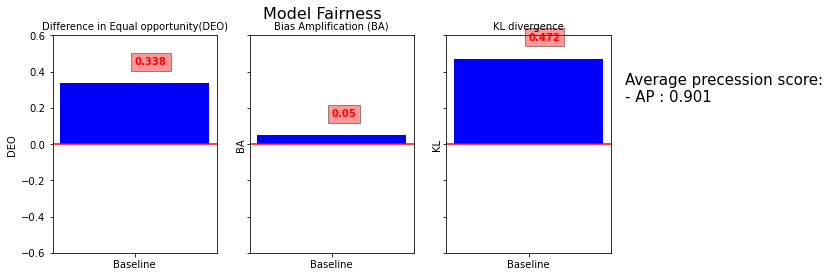

Test results: 
AP : {:.1f} 90.07674037703093
DEO : {:.1f} 33.77429842269778
BA : {:.1f} 5.048403202324144
KL : {:.1f} 0.47201454608638516


In [8]:
test_targets, test_scores = attribute_classifier_model.get_scores(test)
test_pred = np.where(test_scores > cal_thresh, 1, 0)

ap = utils.get_average_precision(test_targets[:, 0], test_scores)
deo = utils.get_difference_equality_opportunity(test_targets[:, 1],
                                                     test_targets[:, 0], test_pred)
ba = utils.get_bias_amplification(test_targets[:, 1],
                                     test_targets[:, 0], test_pred)
kl = utils.get_kl_divergence(test_targets[:, 1], test_targets[:, 0], test_scores)

# plot the fairness
utils.plot_fairness_multi(deo,ba,kl,ap,"Baseline")

print('Test results: ')
print('AP : {:.1f}', 100 * ap)
print('DEO : {:.1f}', 100 * deo)
print('BA : {:.1f}', 100 * ba)
print('KL : {:.1f}', kl)

As seen in the above plots, predictions are definitely not fair when considered in the context of male as a sensitive attribute.

How to mitigate this bias?

Mitigate the bias in General,

1. Remove the bias from the dataset itself and train the model, as illustrated in the GAN data debiasing tutorial.
2. Constrain the model so that it is forced into making fairer predictions.

In the next section, we will show you how the second approach helps in making fair decisions using adversarial training.

### 4. Mitigate the model bias with Adversarial networks



Adversarial debiasing procedure takes inspiration from GANs (Goodfellow et al. 2014) for training a fair classifier. In GANs the technique of using multiple networks with competing goals to force the first network to “deceive” the second network, applies this method to the problem of creating real-life-like pictures. Beutel et al. (2017) apply an adversarial training method to achieve EQUALITY OF OPPORTUNITY in cases when the output variable is discrete. They also discuss the ability of the adversary to be powerful enough to enforce a fairness constraint even when it has access to a very small training sample. Likewise, in adversarial debiasing, we build two models:

1. Target classifier, which predicts the target variable based on input features (training data).
2. Domain classifier, tries to predict, the sensitive attribute based on the predictions of the classifier model

The figure below illustrates the adversarial training procedure.

In [ ]:
img = cv2.imread('images/adversarial_debiasing_training_daigram.png')
cv2_imshow(img)

As shown in the above Fig, at first the Classifier model will generate predictions $\hat{y}$ based on the input ${X}$, As in Figure, we assume that the model is trained by attempting to modify weights $W$ to minimize some loss $Loss_{clf}(\hat{y},y)$, using a gradient-based method such as stochastic gradient descent. The output layer of the "Classifier" is then used as an input
to another network called the "Adversary"(domain classifier) which attempts to predict $\hat{Z}$. This is part of the network that corresponds to the discriminator in a typical GAN. We will suppose the adversary has loss term $Loss_{adv}(\hat{Z}, Z)$ and weights $U$ in the figure.

The Classifier and Adversarial networks are trained to turn by turn (in the form of a zero-sum game, where one agent's gain is another agent's loss) to minimize the loss of both the networks.

For the Classifier, the objective is two-fold: make the best possible predictions while ensuring that sensitive attributes cannot be derived from them. This is captured by the following objective function
$$ \min[Loss_{clf}-\lambda Loss_{adv}]$$

So, it learns to minimize its own prediction losses while maximizing that of the adversarial (due to $\lambda$ being positive and minimizing a negated loss is the same as maximizing it). Note that increasing the size of $\lambda$ steers the classifier network towards fairer predictions while sacrificing prediction accuracy. here we are giving a slight edge to the adversary (domain classifier) network in learning. The loss function for the classifier is changed to its original loss plus the weighted negative adversarial loss.

In Short : 

Train the adversarial and classifier networks simultaneously: 
* Train the classifier network for a single epoch while keeping the adversarial fixed.
* Train the Adversarial (domain network) for two epochs while keeping the classifier fixed

We have trained the Adversarial model and saved model with best accuracy on validation set. If you want to train the Adversarial model from the scratch please refer to our GitHub page and follow the steps.


Now let us get the pre-trained weights for the Adversarial and load the model. Then we shall check model fairness.

In [9]:
!wget https://nnabla.org/pretrained-models/nnabla-examples/responsible_ai/adversarial_debiasing_images/best_adversarial.h5
!wget https://nnabla.org/pretrained-models/nnabla-examples/responsible_ai/adversarial_debiasing_images/val_adversarial.pkl

--2022-04-20 11:42:08--  https://nnabla.org/pretrained-models/nnabla-examples/responsible_ai/adversarial_debiasing_images/best_adversarial.h5
Resolving nnabla.org (nnabla.org)... 204.246.164.102, 204.246.164.110, 204.246.164.18, ...
Connecting to nnabla.org (nnabla.org)|204.246.164.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111404840 (106M) [binary/octet-stream]
Saving to: ‘best_adversarial.h5’

best_adversarial.h5 100%[===================>] 106.24M  8.23MB/s    in 12s     

2022-04-20 11:42:21 (8.55 MB/s) - ‘best_adversarial.h5’ saved [111404840/111404840]

--2022-04-20 11:42:21--  https://nnabla.org/pretrained-models/nnabla-examples/responsible_ai/adversarial_debiasing_images/val_adversarial.pkl
Resolving nnabla.org (nnabla.org)... 204.246.164.41, 204.246.164.18, 204.246.164.110, ...
Connecting to nnabla.org (nnabla.org)|204.246.164.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 365 [binary/octet-stream]
Saving to: ‘val

In [10]:
nn.clear_parameters()

adversarial_model = adv.adversarial(model_load_path=r'best_adversarial.h5')
# split the dataset
split_celeba_dataset(r'./data/celeba/images', r'./data/celeba/list_attr_celeba.txt', r'./test',split="test")
# load dataloader
test = data_iterator_celeba(img_path= r'./test',
                            attr_path= r'./data/celeba/list_attr_celeba.txt',
                            target_attribute ='Attractive', protected_attribute = 'Male',
                            batch_size=32)

cal_thresh = pickle.load(open(r'val_adversarial.pkl', 'rb'))['cal_thresh']

2022-04-20 11:42:30,167 [nnabla][INFO]: Downloading Resnet-50.nnp from https://nnabla.org/pretrained-models/nnp_models/imagenet/Resnet-50/Resnet-50.nnp
2022-04-20 11:42:30,168 [nnabla][INFO]: > /home/ubuntu/nnabla_data/nnp_models/imagenet/Resnet-50.nnp already exists.
2022-04-20 11:42:30,169 [nnabla][INFO]: > If you have any issue when using this file, 
2022-04-20 11:42:30,169 [nnabla][INFO]: > manually remove the file and try download again.


Loading /home/ubuntu/nnabla_data/nnp_models/imagenet/Resnet-50.nnp.
splitting completed


2022-04-20 11:42:51,778 [nnabla][INFO]: DataSource with shuffle(False)
2022-04-20 11:42:51,780 [nnabla][INFO]: Using DataIterator


### Model Fairness for Adversarial networks

0.9126637298875442


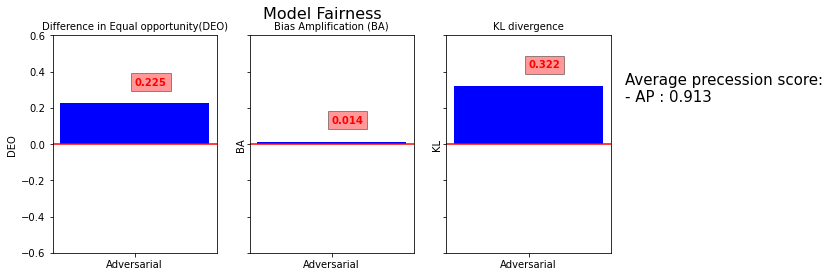

Test results: 
AP : {:.1f} 91.26637298875441
DEO : {:.1f} 22.492274320876504
BA : {:.1f} 1.420760027939729
KL : {:.1f} 0.3221146589957019


In [11]:
test_targets, test_scores = adversarial_model.get_scores(test)
test_pred = np.where(test_scores > cal_thresh, 1, 0)

ap = utils.get_average_precision(test_targets[:, 0], test_scores)
deo = utils.get_difference_equality_opportunity(test_targets[:, 1],
                                                     test_targets[:, 0], test_pred)
ba = utils.get_bias_amplification(test_targets[:, 1],
                                     test_targets[:, 0], test_pred)
kl = utils.get_kl_divergence(test_targets[:, 1], test_targets[:, 0], test_scores)
utils.plot_fairness_multi(deo,ba,kl,ap,"Adversarial")
print('Test results: ')
print('AP : {:.1f}', 100 * ap)
print('DEO : {:.1f}', 100 * deo)
print('BA : {:.1f}', 100 * ba)
print('KL : {:.1f}', kl)

The plots above show how the model fairness improved (AP, DEO, BA & KL have improved compared to the baseline model) after adversarial debiasing training. However, in some cases after adversarial training, the accuracy of classification may drop (reduction in accuracy can be controlled). We end up with a classifier that makes fair predictions when it comes to Gender as a sensitive attribute. Decent outcome!

### 5. Summary
 
In this tutorial, we demonstrate a general and powerful method for training and mitigating the bias for Resenet-50 pre-trained classifier using `Adversarial debiasing procedure`. And yes, making fair predictions comes at a cost: sometimes it will reduce the performance of our model (hopefully, only by a little). However, in many cases, this will be a relatively small price to pay.

### 6. References

1. Zhang, Brian Hu, Blake Lemoine, and Margaret Mitchell. "Mitigating unwanted biases with adversarial learning." Proceedings of the 2018 AAAI/ACM Conference on AI, Ethics, and Society. 2018.
2. Beutel, Alex, et al. "Data decisions and theoretical implications when adversarially learning fair representations." arXiv preprint arXiv:1707.00075 (2017).
3. Hardt, Moritz, Eric Price, and Nati Srebro. "Equality of opportunity in supervised learning." Advances in neural information processing systems 29 (2016).
4. Wang, Zeyu, et al. "Towards fairness in visual recognition: Effective strategies for bias mitigation." Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2020.
5. Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems 27 (2014).
6. Liu, Ziwei, et al. "Large-scale celebfaces attributes (celeba) dataset." Retrieved August 15.2018 (2018): 11.
7. Kingma, Diederik P., and Jimmy Ba. "Adam: A method for stochastic optimization." arXiv preprint arXiv:1412.6980 (2014).
8. Lokhande, Vishnu Suresh, et al. "Fairalm: Augmented lagrangian method for training fair models with little regret." European Conference on Computer Vision. Springer, Cham, 2020.
9. Wang, Angelina, and Olga Russakovsky. "Directional bias amplification." International Conference on Machine Learning. PMLR, 2021.
10. Chen, Mingliang, and Min Wu. "Towards threshold invariant fair classification." Conference on Uncertainty in Artificial Intelligence. PMLR, 2020.